<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Camembert_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CamemBERT classification model 


## Set up colab GPU and installing main packages

In [0]:
# If you have the documents in your drive already otherwise just drag 'medium_df_desequ.csv' and 'funct.py' in the file section
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

In [2]:
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf

# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

We now can tell torch that one GPU is available 

In [3]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
!nvidia-smi

Sun Apr  5 15:32:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  



**Please check GPU capacity** that you were given. You might want to reduce the batch size further in the code.  Typically if you were given 8Go memory GPU (Tesla P4) you should set the batch size to 2 not more ! 

We now install the Hugging Face library transformers. You can find all the documentation of hugging face in their Github : https://github.com/huggingface/transformers  

In [5]:
! pip install transformers 

     |████████████████████████████████| 552kB 4.9MB/s 
     |████████████████████████████████| 3.7MB 20.9MB/s 
     |████████████████████████████████| 870kB 58.7MB/s 
     |████████████████████████████████| 1.0MB 52.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=114e2408814933af23e29472c8afaba66c8fb999495f9563ac701107b079c06d
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


## Loading our corpus and preparing samples 

In [0]:
# We keep the same seed value all along this notebook in order to be able to replicate the results 
seed_val = 42

In [7]:
# Import medium_df_desq in "files" (on the left) this can take some time ! 
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
df=pd.read_csv('medium_df_deseq.csv',encoding='utf-8')

# Shuffle the date
df=df.sample(frac=1,random_state=seed_val).reset_index(drop=True)

# Some of the speeches are interviews (wrongly classified in the website) we try to delete most of them  
df=df[~df.Texte.str.startswith("Q-")]
df=df[~df.Texte.str.startswith("R-")]
df=df[df.Id!=169898] # FOr some reason a problem on this text occured for preprocessing

# Normalization of the labels [0,1] instead of [1,2] (0 = men, 1 = women)
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)

# We keep only variables of interest 
df=df[['Id','Titre','Theme','Prenom','Nom','Date','Tags','Texte','sexe']]

# For the cleaning part we will just remove urls, parenthesis and double spacing if any 
import re
def cleaning_stuff(text):
    text = re.sub(r" \(.*?\)", '', text, flags=re.MULTILINE)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = text.replace('(',' ')
    text = text.replace(')',' ')
    text = text.replace('.  ','. ')
    text = text.replace('  ','')
    text=text.replace(" :'","") 
    text = text.strip()
    text = text.replace("\'","'")
    return text 

df['Texte']=df.Texte.apply(cleaning_stuff)
df=df[df.Texte!='']

df = df[~df.Titre.str.startswith('Déclaration conjointe')]
# This is a sample of our dataset
df.head(5)

,Id,Titre,Theme,Prenom,Nom,Date,Tags,Texte,sexe
0,167276,"Déclaration de M. François Fillon, Premier min...",International,François,Fillon,2007-07-13T12:00:00Z,"Relations internationales,Relations bilatérale...","Monsieur le président du Conseil, Mesdames et ...",0
1,177180,"Déclaration de M. François Fillon, Premier min...",NaN,François,Fillon,2009-11-12T12:00:00Z,NaN,"Mesdames et Messieurs les Ministres,Mesdames e...",0
2,173356,"Déclaration de M. François Fillon, Premier min...",Economie,François,Fillon,2008-12-09T12:00:00Z,"Energie - Transports,Transport routier",Monsieur le Conseiller d'Etat de la République...,0
3,170644,"Déclaration de M. Bernard Kouchner, ministre d...",Société,Bernard,Kouchner,2008-05-05T12:00:00Z,"Culture - Médias,Presse",A l'occasion de la 18ème journée international...,0
4,131071,"Déclaration de M. Nicolas Sarkozy, ministre de...",Société,Nicolas,Sarkozy,2002-06-25T12:00:00Z,"Sécurité,Police","Mesdames et Messieurs les commissaires, Au ter...",0


In [8]:
print(df.Texte[200])

Monsieur le président, cher Bruno Favier,Mesdames, messieurs,A l'occasion de la récente Journée mondiale de la maladie de Parkinson, je me retrouve parmi vous aujourd'hui avec satisfaction mais aussi avec gravité.Les premiers Etats généraux des personnes touchées par la maladie de Parkinson ont permis la rédaction d'un Livre Blanc, à l'initiative de l'association France-Parkinson.A vous, son président, cher Bruno Favier - dont j'ai vu avec plaisir le nom figurer dans la promotion de Pâques de la Légion d'honneur -, ainsi qu'à toutes celles et tous ceux qui oeuvrent avec vous au service des malades et de leurs familles, je veux adresser mes plus vifs remerciements.Je connais le remarquable investissement dont vous faites preuve quotidiennement pour soutenir celles et ceux qui souffrent et changer le regard de chacun sur cette maladie mal connue.L'ouvrage que vous venez de me remettre est le fruit d'un important travail de concertation, qui a su fédérer les énergies et auquel ont pris pa

In [17]:
# Import medium_df_desq in "files" (on the left) this can take some time ! 
import pandas as pd
import numpy as np

# Load the dataset into a pandas dataframe.
df_balanced=pd.read_csv('medium_df_eq.csv',encoding='utf-8')

# Shuffle the date

# Some of the speeches are interviews (wrongly classified in the website) we try to delete most of them  
df_balanced=df_balanced[~df_balanced.Texte.str.startswith("Q-")]
df_balanced=df_balanced[~df_balanced.Texte.str.startswith("R-")]
df_balanced=df_balanced[df_balanced.Id!=169898] # FOr some reason a problem on this text occured for preprocessing

# Normalization of the labels [0,1] instead of [1,2] (0 = men, 1 = women)
df_balanced.sexe=df_balanced.sexe.replace(1,0)
df_balanced.sexe=df_balanced.sexe.replace(2,1)

# We keep only variables of interest 
df_balanced=df_balanced[['Id','Titre','Theme','Prenom','Nom','Date','Tags','Texte','sexe']]

# For the cleaning part we will just remove urls, parenthesis and double spacing if any 
import re
def cleaning_stuff(text):
    text = re.sub(r" \(.*?\)", '', text, flags=re.MULTILINE)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    text = text.replace('(',' ')
    text = text.replace(')',' ')
    text = text.replace('.  ','. ')
    text = text.replace('  ','')
    text=text.replace(" :'","") 
    text = text.strip()
    text = text.replace("\'","'")
    return text 

df_balanced['Texte']=df_balanced.Texte.apply(cleaning_stuff)
df_balanced=df_balanced[df_balanced.Texte!='']

df_balanced = df_balanced[~df_balanced.Titre.str.startswith('Déclaration conjointe')]
# This is a sample of our dataset
df_balanced.head(5)

,Id,Titre,Theme,Prenom,Nom,Date,Tags,Texte,sexe
0,133642,"Déclaration de M. Hervé de Charette, ministre ...",International,Hervé,de Charette,1997-01-13T12:00:00Z,"Relations internationales,Relations bilatérale...","Mesdames et Messieurs, j'ai été très heureux d...",0
1,201364,"Déclaration de M. Michel Sapin, ministre de l'...","Economie,Institutions",Michel,Sapin,2016-11-29T12:00:00Z,"Vie économique,Gestion d'entreprise,Justice - ...","Monsieur le Président,Monsieur le Président de...",0
2,272549,"Déclaration de M. Emmanuel Macron, Président d...",International,Emmanuel,Macron,2019-12-21T12:00:00Z,"Afrique,Côte d'Ivoire","Merci beaucoup Monsieur le Président, cher Ala...",0
3,175752,"Déclaration de M. Guy Hascoët, secrétaire d'Et...",Economie,Guy,Hascoët,2001-05-31T12:00:00Z,"Vie économique,Economie sociale",En ce moment l'Europe est à l'ordre du jour. L...,0
4,186046,Déclaration à la presse de MM. François Hollan...,International,François,Hollande,2012-10-09T12:00:00Z,"Relations internationales,Relations bilatérale...","François HOLLANDE : Mesdames et Messieurs, j'a...",0


**We propose 3 samples to train our model :**


**1.   Unbalanced sample**

We take the raw data without any further treatment.

**2.   Balanced sample**

The second option consists in deleting randomly part of male speeches in order to get a balanced sample. Indeed, in the case of unbalanced sample our model could decide to classify all speakers in the male category which would lead to a 0.75 accuracy in our case study. In order to avoid this we feed the model with the same proportions of male and female speakers. Other kind of treatments exist to deal with unbalanced sample. This one is the simpliest one and we could argue that there is a possibility that the deleted sample contains important information that we therefore miss. However we believe that in our case this is not a big issue. Our unbalanced sample is quite large for both female and male.

**3. Balanced and splitted sample**

The third option is a response to the max length constraint of BERT models. Our text samples are big and contain much more tokens than the 512 limit. In the first two options we decide to feed the model with the 512 first tokens and thus we delete the remaining tokens. In this third option we cut the text into x parts containing 500 tokens each. All parts of the speech will serve to feed the model. Through this technique we do not loose potential important informations at the end of the text. A lot of other techniques have been employed such as hierarchical transformers (see our latex for reference). We decide to stick to this method in this project but it is an obvious improvment that could be added here. 



In [0]:
def unbalanced_preprocess(df):
  ''' 
  This function just takes our unbalanced dataset and prints relevant informations
  '''

  df_unbalanced=df

  # Reports the number of speeches in the corpus.
  print('Number of text in the unbalanced corpus : {0:.2f}\n'.format(df_unbalanced.shape[0]))

  # Reports the percentage of women in the sample 
  prop = (len(df_unbalanced[df_unbalanced.sexe==1])/len(df_unbalanced))*100
  print('Percentage of women in the unbalanced corpus : {0:.2f}\n'.format(prop))

  return df_unbalanced

In [12]:
df_unbalanced = unbalanced_preprocess(df) 

Number of text in the unbalanced corpus : 4977.00

Percentage of women in the unbalanced corpus : 25.12



In [0]:
def balanced_preprocess(df,seed_val,frac_val):
  ''' 
  This function transforms our unbalanced dataset by deleting male speeches

  Input : 
          df : dataframe
          frac_val : fraction of the sample we want (this is mainly here for testing if you want to train your model with less data)

  Output : 
          df_balanced : A balanced version of our dataset with the same proportion of men and women
  '''

  # Reports the number of speeches in the corpus.
  print('Number of text in this corpus : {0:.2f}\n'.format(df.shape[0]))

  # Reports the percentage of women in the sample 
  prop = (len(df[df.sexe==1])/len(df))*100
  print('Percentage of women in the balanced corpus : {0:.2f}\n'.format(prop))

  return df



In [18]:
df_balanced = balanced_preprocess(df_balanced,seed_val,frac_val=1)

Number of text in this corpus : 4986.00

Percentage of women in the balanced corpus : 50.10



In [0]:
import pandas as pd
def sent_detector_mano(x):
    """
        Détection de phrase à la main.
        Input : document
        Output : liste de phrases
        Problème avec les phrases finissant par : entrainant souvent une liste. 
        De même avec ;. Tentative réalisée
        
    """
    lst =[]
    phrase = []
    i = 0
    for caractere in x: 
        if not (caractere == ' ' and len(phrase) == 0) :
            phrase.append(caractere)
        if caractere in '?!.:;':
            if caractere == ':':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            if caractere == ';':
                if x[i+1].isupper() or x[i+2].isupper() or x[i+1] == '-' or x[i+2] == '-':
                    lst.append(''.join(phrase))
                    phrase = []
            elif phrase != '.' or phrase != '?' or phrase != '!':
                lst.append(''.join(phrase))
                phrase = []
        i+=1
    return lst
def split_document_to_limit(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = []
    for token in row.Texte.split(' '):
      if len(phrase) < MAX_TOKENS:
        phrase.append(token)
      else:
        lst += [(identifiant,label,' '.join(phrase),len(phrase))]
        phrase = []
    if len(phrase)>1:
      lst += [(identifiant,label,' '.join(phrase),len(phrase))]
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])
def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
def  balanced_splitted(df,seed_val,frac_val,max_tokens):
  
  df=df[df.Texte!='']

  df=split_document_to_limit_phrases(max_tokens,df)
 
  df=df[df.Texte!='']


  # Report the number of speeches in the corpus.
  print('Number of text in this balanced splitted corpus : {:,}\n'.format(df.shape[0]))
  prop = (len(df[df.sexe==1])/len(df))*100
  print('Proportions of women in the balanced splitted corpus : {}\n'.format(prop))

  return df

In [22]:
df_balanced_split = balanced_splitted(df_balanced,seed_val,frac_val=1,max_tokens=450)

Number of text in this balanced splitted corpus : 22,386

Proportions of women in the balanced splitted corpus : 49.906191369606



## Tokenization and preparing to feed CamemBERT

### Loading the Camembert Tokenizer

In [23]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [24]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  Monsieur le président du Conseil, Mesdames et Messieurs les ministres, Mesdames et Messieurs les parlementaires, Mesdames et Messieurs les ambassadeurs, Mesdames et Messieurs, Et mes chers compatriotes, Permettez-moi d'abord de vous remercier, cher Romano Prodi, d'être venu ici, au palais Farnèse, pour célébrer avec nous notre Fête nationale. Votre présence aujourd'hui et celle de tant de personnalités italiennes, dans ce magnifique palais de la Renaissance que l'Italie a bien voulu nous confier pour en faire la plus belle de nos ambassades, est la marque de l'amitié forte qui unit nos deux pays et nos deux peuples. Le 14-Juillet est pour nous, Français, un anniversaire que nous sommes particulièrement heureux de célébrer en compagnie de tous les amis de la liberté et de la démocratie. Je veux donc aussi remercier chaleureusement toute la communauté diplomatique réunie ici aujourd'hui. Cher Romano Prodi, j'ai souhaité me rendre à Rome dans les plus brefs délais après ma nom

### Preparing to feed the model : adding special tokens, attention masks and transform into tensors


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text Moreover, for camembert we should add a space between CLS and the first token (not sure here, we have to ask benjamin). 

2.   **Pad and truncate all texts to a single number**

Pretrained transformes like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the library which is really convenient. 



In [0]:
length = 500
batch_size_value = 16
length_train=0.8
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [26]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_unbalanced.Texte.values
labels = df_unbalanced.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_unbalanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_unbalanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  Monsieur le président du Conseil, Mesdames et Messieurs les ministres, Mesdames et Messieurs les par
IDs: tensor([    5,  2445,    16,   668,    25,   960,     7, 23605,    14, 19923,
           19,  7427,     7, 23605,    14, 19923,    19, 12680,     7, 23605,
           14, 19923,    19,    21,  9645,    10,     7, 23605,    14, 19923,
            7,   139,   249,  6175, 16681,    10,     7, 14378,  4731,    26,
         2279,    18,    11,   803,     8,    39,  5559,     7,   661,  6900,
          189,  1092,  1060,     7,    18,    11,   177,  2412,   323,     7,
           36,  5408,  6845, 19947,    35,     7,    24, 10003,    42,    63,
          127,  7202,   945,     9,  1268,   922,   405,    11,   265,    14,
          386,     8,   376,     8,  6882,  5334,    10,     7,    29,    44,
         1509,  5408,     8,    13, 13460,    27,    17,    11,  5091,    33])
Attention masks: tensor([1, 1, 1,

In [27]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced.Texte.values
labels = df_balanced.sexe.values
length = 500
batch_size_value = 16
length_train=0.8
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])


# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:  Mesdames et Messieurs, j'ai été très heureux de recevoir aujourd'hui Mme Pesic, responsable de l'all
IDs: tensor([    5, 23605,    14, 19923,     7,    76,    11,    73,   101,    95,
         1941,     8,  1653,   405,    11,   265,  2439,  2997, 12219,     7,
         1295,     8,    17,    11, 11193, 16552,    42,   745,    63,   296,
        12199, 12997,    13,   595,    31, 30827,   405,    11,   265,    15,
         3845, 11602,    35,     9,  2439,  2997, 12219,   115,    11,    55,
          804,     8,   429, 10012,     7,    17,    11,  2153,     8,    13,
          595,     7,    16,   299,     8,   477,    14,    19,  1161,    31,
           56,    19, 11017,    10,    14,   989,     8,    17,    11,  4244,
           24,  1077,    13, 25389,     8,    13,  1662,   462,  4440,    29,
          745,   109,    48,   396,     9,   100,  4318,    39,  3318,     7])
Attention masks: tensor([1, 1, 1,

In [28]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
length = 500
batch_size_value = 8
length_train=0.8

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

Let's check for the first text indexes, attention masks and labels
 
Original:   Mesdames et Messieurs, j'ai été très heureux de recevoir aujourd'hui Mme Pesic, responsable de l'al
IDs: tensor([    5, 23605,    14, 19923,     7,    76,    11,    73,   101,    95,
         1941,     8,  1653,   405,    11,   265,  2439,  2997, 12219,     7,
         1295,     8,    17,    11, 11193, 16552,    42,   745,    63,   296,
        12199, 12997,    13,   595,    31, 30827,   405,    11,   265,    15,
         3845, 11602,    35,     9,  2439,  2997, 12219,   115,    11,    55,
          804,     8,   429, 10012,     7,    17,    11,  2153,     8,    13,
          595,     7,    16,   299,     8,   477,    14,    19,  1161,    31,
           56,    19, 11017,    10,    14,   989,     8,    17,    11,  4244,
           24,  1077,    13, 25389,     8,    13,  1662,   462,  4440,    29,
          745,   109,    48,   396,     9,   100,  4318,    39,  3318,     7])
Attention masks: tensor([1, 1, 1,

5 and 6 seem to be the [CLS] and [SEP] special tokens 


## CamemBERT Sequence Classification model tuning


### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [30]:
# Loading the model
gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [31]:
# We run the model on the colab GPU 
gender_model.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

### Constructing the training and validation loop 


In [0]:
import numpy as np

from sklearn.metrics import f1_score 

def create_report(labels,preds) : 
  pred_flat= np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  F1_score = f1_score(labels_flat,pred_flat,zero_division=1)
  Accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
  return F1_score, Accuracy

In [0]:
def train_val_gendermodel(train_loader, val_loader, epochs_val,seed_val,device,lr_value):

  ############################  IMPORT MODEL ################################################
  from transformers import CamembertForSequenceClassification
  gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, )

  model = gender_model
  model.cuda()
  
  ############################## RANDOM SEED ##################################################

  import random
 # Let's put a seed to make this result reproducible 
  seed=seed_val
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  ############################### LEARNING RATE SCHEDULER #######################################

  # https://huggingface.co/transformers/migration.html 
  # https://pytorch.org/docs/stable/optim.html (default values)

  import torch.nn as nn
  import torch.optim as optim
  from transformers import AdamW
  from transformers import get_linear_schedule_with_warmup

  epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

  # We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
  criterion = nn.BCEWithLogitsLoss()
  #Implements Adam algorithm with weight decay fix.
  opti = AdamW(model.parameters(),
                    lr =lr_value, # learning rate (default = 1e-3)
                    eps = 1e-8 # prevents division by 0 (default = 1e-8)
                  )

  num_training_steps = len(train_loader) * epochs
  # Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
  scheduler = get_linear_schedule_with_warmup(opti, 
                                              num_warmup_steps = 0,
                                              num_training_steps = num_training_steps)
  
  
  # We want to evaluate the training phase 
  training_stats = []

  for ep in range(0, epochs):
    print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
    print('Training starts')

    ################################### TRAINING ################################

    #Put the model in training mode
    model.train()

    # Set the train loss for the epoch to 0 
    total_train_loss = 0

    for step, batch in enumerate(train_loader):
      # Clear gradients 
      model.zero_grad() # (opti.zerograd ? )

      # Cpy the 3 batch to GPU 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      #return loss and logits
      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels) 
      
      # Accumulate training loss for all batches 
      total_train_loss += loss.item()

      #Backpropagating the gradients 
      loss.backward()

      # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters 
      opti.step()

      # Update learning rate schedule
      scheduler.step()

    #Calculate the average training loss over all batches  
    avg_train_loss = total_train_loss / len(train_loader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print('')
    print('Validation starts')

    ###################### VALIDATION #############################

    # Put model in evaluation mode 
    model.eval()

    # Set statistics to 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_f1=0
    total_roc_auc = 0 

    # Confusion matrix ?
    predictions, true_labels = [], []

    for batch in val_loader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      # We don't care about gradients for eval

      with torch.no_grad(): 
        (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
      total_eval_loss += loss.item()

        # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      F1_score, Accuracy = create_report(label_ids,logits)

      # Accumulation accuracy for all batch
      total_eval_accuracy += Accuracy

      # Accumulation f1 for all batch
      total_eval_f1 += F1_score

      
      #Final accuracy on all batch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      #Final f1 on all batch
    avg_val_f1 = total_eval_f1 / len(val_loader)
    print("  F1_score: {0:.2f}".format(avg_val_f1))

      #Final loss over all batch
    avg_val_loss = total_eval_loss / len(val_loader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
          {
              'epoch': ep + 1,
              'Train Loss': avg_train_loss,
              'Val Loss': avg_val_loss,
              'Val Accur.': avg_val_accuracy,
              'Val F1' : avg_val_f1,
          }
      )

  print("")
  print("Done !")

  return  training_stats

In [0]:
def report_model_1(results):
  '''
  Input : statistics of the model 
  Output : training and valid loss 
  ''' 
  df_stats = pd.DataFrame(data=results)
  df_stats = df_stats.set_index('epoch')
  print(df_stats)

  import matplotlib.pyplot as plt
  % matplotlib inline
  import seaborn as sns

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Train Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Val Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4, 5])

  plt.show()

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=5,seed_val=42,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 5 ==============
Training starts

  Average training loss: 0.42

Validation starts


In [0]:
report_model_1(results_unbalanced)

In [0]:
results_balanced = train_val_gendermodel(train_loader=train_loader_balanced, val_loader=val_loader_balanced, epochs_val=5,seed_val=42,device=device,lr_value=5e-5)

In [0]:
report_model_1(results_balanced)

In [0]:
results_balanced_split = train_val_gendermodel(train_loader=train_loader_balanced_split, val_loader=val_loader_balanced_split, epochs_val=5,seed_val=42,device=device,lr_value=5e-5)

In [0]:
report_model_1(results_balanced_split)

**Overall Performance** : As expected we see that training on a balanced dataset avoid the model to be biased toward men. F1 score is much higher for the balanced sample. 

**Number of epoches** : According to the train and valid loss, 2 to 3 epochs are enough in order to train the model efficiently. More epochs would lead to an overfitting on the training sample. 

**Token limitation** : Let's now compare the method consisting in using only the first 500 token of the texte and the entire text. We have similar results in terms of metrics. We were not expecting such a high result for the second model to begin with but it seems that learning on the first paragraph is enough to be able to classify all them after. 

**Final choice** : Even if the second model is already satisfying, the second might be easier to generalized after and displays higher metrics. We will use the third one in the rest of this section. 

### Training the optimal model 

In [0]:
df_eval= balanced_splitted(df_balanced,seed_val,frac_val=1,max_tokens=450)

In [0]:
# We prepare another sample which will be dedicated to further qualitative analysis

In [0]:
len_train = round(0.97*len(df_eval))
df_balanced_split= df_eval[0:len_train]
dev_balanced_split=df_eval[len_train:len(df_eval)]

# Report the number of speeches in the corpus.
print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
print('Number of text in the development sample : {:,}\n'.format(dev_balanced_split.shape[0]))

In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

texts = df_balanced_split.Texte.values 
labels = df_balanced_split.sexe.values

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
length = 500
batch_size_value = 16
length_train=0.9

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = length,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(length_train * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])


print("-------------------------------------------------")
print(" ")
print("How many texts do we have in the train and validation sample ? ")
print(" ")
print('We have {} training texts'.format(train_size))
print('We have {} validation texts'.format(val_size))
print(" ")
print("-------------------------------------------------")

# We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
batch_size = batch_size_value

# We create data loaders for the train and validation dataset. 
train_loader_balanced_split = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_loader_balanced_split = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

print('Data loaders created for train [0] and val [1]')

In [0]:

############################  IMPORT MODEL ################################################
from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained("camembert-base", 
                                                                  num_labels = 2, 
                                                                  output_attentions = False, 
                                                                  output_hidden_states = False, )

gender_model.cuda()
############################## RANDOM SEED ##################################################

import random
seed=seed_val
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 3 

#Implements Adam algorithm with weight decay fix.
opti = AdamW(gender_model.parameters(),
              lr =5e-5, # learning rate (default = 1e-3)
              eps = 1e-8 # prevents division by 0 (default = 1e-8)
            )

num_training_steps = len(train_loader_balanced_split) * epochs

# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                            num_warmup_steps = 0,
                                            num_training_steps = num_training_steps)


for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  gender_model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(train_loader_balanced_split):
    # Clear gradients 
    gender_model.zero_grad() # 

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = gender_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(gender_model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_loader_balanced_split)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))

In [0]:
torch.save( gender_model, 'gender_model_train.pt')

In [0]:
gender_model = torch.load('gender_model_train.pt')

## Quantitative evaluation and qualitative analysis 

### Quantitative analysis of the final model

In [0]:
 def evaluation_loop(model,eval_loader): 
  # Put model in evaluation mode 
  model.eval()
  total_eval_loss,total_pred,total_label,total_logits=[],[],[],[]

  for batch in eval_loader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad(): 
      loss, logits = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
    #total_eval_loss += loss.item()

      # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      pred= np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()

    # Accumulation accuracy for all batch
      total_pred += pred.tolist()

    # Accumulation f1 for all batch
      total_label += labels_flat.tolist()

      # Logits score on positive 
      total_logits += logits.tolist()

  return total_pred,total_label,total_logits

In [0]:
total_pred,total_label,total_logits =evaluation_loop(gender_model,val_loader_balanced_split)

In [0]:
def model_report(pred,label,logits):
    """
        Input :
            pred : model prediction
        Output : 
            Classification_report + Confusion_matrix + ROC_curve
    """
    #from sklearn
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
    logits = [el[1] for el in total_logits]
    pred = [i for i in total_pred]
    label = [i for i in total_label]
    print ("Classification report :")
    print(classification_report(label,pred))
    print ("Accuracy : ",accuracy_score(label,pred))
    cm = confusion_matrix(label,pred)
    ROC = roc_auc_score(label,pred) 
    print ("AUC : ",ROC)
    fpr,tpr,thresholds = roc_curve(label,logits)
    plt.figure(figsize=(12,10))
    plt.subplot(221)
    sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues').set_title('Matrice de confusion')
    plt.subplot(222)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % ROC)
    plt.plot([0,1],[0,1],color='red')
    plt.title('Courbe ROC')
    plt.show()

In [0]:
model_report(total_pred,total_label,logits)

The model seem to be slightly more performant at predicting female speakers than male speakers. We reach good metrics for both accuracy and F1 score. More than 80 % of our predictions are correct. 


### Qualitative analysis

We will use our development set prepared earlier 

In [0]:
# We prepare again the development sample for analysis 
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = dev_balanced_split.Texte.values
labels = dev_balanced_split.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 16, # Trains with this batch size.
            shuffle=False
        )

In [0]:
# We make this development sample pass into the evaluation loop 
total_pred,total_labels,total_logits=evaluation_loop(gender_model,dev_dataloader)

In [0]:
def dev_treatment(total_pred,total_labels,total_logits,dev_balanced_split,df):
  ''' 
  This function takes as input the results of the models, compute some statistics and merges the results
  with our first dataset

 Input : 
        model predictions, model labels, model scores, development sample and original data
 Output : 
        merged dataset
  '''
  # Extract the score for label 1 and the maximum score 
  one_score = [el[1] for el in total_logits]
  max_score = np.max(total_logits,axis=1)

  # Put everything inside a dataframe
  results_dev=pd.DataFrame([total_labels,total_pred,one_score,max_score]).transpose()
  results_dev.columns=['returned_labels','model_pred','one_score','max_score']
  results_dev['WF']=pd.DataFrame([results_dev['model_pred']==results_dev['returned_labels']]).transpose()
  results_dev['model_pred'] = results_dev['model_pred'].astype(int)
  results_dev['returned_labels'] = results_dev['returned_labels'].astype(int)

  # Merge back with the text
  frames = [dev_balanced_split[['Texte','sexe','index_df']].reset_index(), results_dev]
  result = pd.concat(frames,axis=1)

  # We merge this dataframe to the information we had at the beginning
  merged_results=result[['index','index_df','Texte','returned_labels','model_pred','one_score','max_score','WF']].merge(df[['Titre','Id','Theme','Prenom','Nom','Date','Tags','sexe']],how='left',left_on='index_df',right_on='Id')

  return merged_results



In [0]:
result =  dev_treatment(total_pred,total_labels,total_logits,dev_balanced_split,df_balanced)

In [0]:
result.head()

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
0,10826,134631,Et c'est bien là que se noue la question esse...,1,1,1.427388,1.427388,True,"Déclaration de Mme Catherine Trautmann, minist...",134631,Institutions,Catherine,Trautmann,1998-01-11T12:00:00Z,"Justice - Droits fondamentaux,Antisémitisme",1
1,10827,170264,C'est un bonheur que de constater la richesse...,1,1,2.155089,2.155089,True,"Déclaration de Mme Roselyne Bachelot, ministre...",170264,Société,Roselyne,Bachelot-Narquin,2007-12-11T12:00:00Z,"Société - Population,Personne âgée",1
2,10828,192891,M. Roland Courteau. Très bien ! Mme Carole De...,1,1,2.370206,2.370206,True,"Déclaration de MMe Carole Delga, secrétaire d'...",192891,Economie,Carole,Delga,2014-10-21T12:00:00Z,"Vie économique,Politique économique",1
3,10829,177095,Mais la crise a bouleversé tous les repères. ...,1,1,0.766086,0.766086,True,"Déclaration de Mme Christine Lagarde, ministre...",177095,Economie,Christine,Lagarde,2009-10-20T12:00:00Z,"Finances publiques,Budget de l'Etat",1
4,10830,144772,"Mesdames, Messieurs, j'ai souhaité, vous le s...",0,0,-1.947491,1.946521,True,"Déclaration de M. Jean-François Mattei, minist...",144772,Société,Jean-François,Mattei,2003-12-10T12:00:00Z,"Santé - Protection sociale,Santé publique",0


In [0]:
#Which texts failed ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

12.54 percent of the development texts were not well classified by our model


For the next step let's take some texts that were well classified and other that do not. We will take examples for all possible options : badly predicted a woman, badly predicted a man, well predicted a woman and well predicted a man. We also try to take the ones the model was really sure about. 

In [0]:
top_texts_true_m=result[(result.WF==1) & (result.model_pred==0)].nlargest(10,'max_score')
top_texts_true_f=result[(result.WF==1) & (result.model_pred==1)].nlargest(10,'max_score')
top_texts_false_m=result[(result.WF==0) & (result.model_pred==0)].nlargest(10,'max_score')
top_texts_false_f=result[(result.WF==0) & (result.model_pred==1)].nlargest(10,'max_score')

In [0]:
# Texts that were well classified as men 
top_texts_true_m.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
147,10973,140199,Je ne suis pas toujours d'accord avec monsieu...,0,0,-2.588010,2.579525,True,"Déclaration de M. Jean-Pierre Raffarin, Premie...",140199,International,Jean-Pierre,Raffarin,2003-10-06T12:00:00Z,"Relations internationales,Relations bilatérale...",0
44,10870,134262,"J'ai confiance, car je connais la vitalité et...",0,0,-2.591268,2.575959,True,"Discours de M. Jacques Chirac, Président de la...",134262,"International,Société",Jacques,Chirac,1997-03-17T12:00:00Z,"Relations internationales,Relations bilatérale...",0
240,11066,142205,La première de ces pistes concerne les perspe...,0,0,-2.577943,2.570937,True,"Déclaration de M. Jean-Pierre Raffarin, Premie...",142205,NaN,Jean-Pierre,Raffarin,2003-12-01T12:00:00Z,NaN,0
281,11107,127710,"De ce point de vue, notre conception est diff...",0,0,-2.563087,2.570248,True,"Déclaration de M. Lionel Jospin, Premier minis...",127710,Institutions,Lionel,Jospin,2002-03-20T12:00:00Z,"Citoyenneté - Elections,Personnalité politique",0
321,11147,186309,"Mesdames, Messieurs,Dans une assemblée qui es...",0,0,-2.585277,2.564062,True,"Déclaration de M. Pascal Canfin, ministre du d...",186309,International,Pascal,Canfin,2012-11-05T12:00:00Z,"Relations internationales,Aide internationale",0
239,11065,133642,"Mesdames et Messieurs, j'ai été très heureux ...",0,0,-2.569544,2.558361,True,"Déclaration de M. Hervé de Charette, ministre ...",133642,International,Hervé,de Charette,1997-01-13T12:00:00Z,"Relations internationales,Relations bilatérale...",0
11,10837,187341,"Et, s'agissant des jeunes les moins qualifiés...",0,0,-2.562876,2.556654,True,"Déclaration de M. Jean-Marc Ayrault, Premier m...",187341,Société,Jean-Marc,Ayrault,2013-02-28T12:00:00Z,"Sciences - Numérique - I. A.,Internet",0
54,10880,146246,"Monsieur le Président,Messieurs les Rapporteu...",0,0,-2.581499,2.555746,True,"Déclaration de M. Galouzeau de Villepin, minis...",146246,Economie,Dominique,de Villepin,2004-11-16T12:00:00Z,"Finances publiques,Budget de l'Etat",0
85,10911,144410,"Monsieur le Président,Mesdames et Messieurs l...",0,0,-2.563626,2.554979,True,"Déclaration de M. Michel Barnier, ministre des...",144410,International,Michel,Barnier,2004-10-19T12:00:00Z,"Relations internationales,Relations bilatérale...",0
223,11049,183629,"Ces devoirs, cette exigence, chacun d'entre v...",0,0,-2.565979,2.553955,True,"Déclaration de M. Nicolas Sarkozy, Président d...",183629,Institutions,Nicolas,Sarkozy,2011-11-23T12:00:00Z,"Institutions de l'Etat,Politique gouvernementale",0


In [0]:
# Texts that were well classified as women 
top_texts_true_f.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
259,11085,207242,pourquoi baisser le budget de l'inspection du...,1,1,2.427634,2.427634,True,"Déclaration de Mme Muriel Pénicaud, ministre d...",207242,NaN,Muriel,Penicaud,2018-11-09T12:00:00Z,Loi,1
262,11088,272410,Il s'agit d'une réponse concrète et d'une pol...,1,1,2.411540,2.411540,True,"Déclaration de Mme Élisabeth Borne, ministre d...",272410,Société,Elisabeth,Borne,2019-10-03T12:00:00Z,"Environnement,Politique de l'environnement,Climat",1
204,11030,272410,"En période de canicule, comme en période de v...",1,1,2.402071,2.402071,True,"Déclaration de Mme Élisabeth Borne, ministre d...",272410,Société,Elisabeth,Borne,2019-10-03T12:00:00Z,"Environnement,Politique de l'environnement,Climat",1
212,11038,269666,Jeux Olympiques et Paralympiques de 2024 Adop...,1,1,2.385171,2.385171,True,"Déclaration de Mme Roxana Maracineanu, ministr...",269666,Société,Roxana,Maracineanu,2019-07-24T12:00:00Z,"Société - Population,Sport",1
168,10994,141170,Il lui appartient donc d'affirmer sa spécific...,1,1,2.382982,2.382982,True,"Déclaration de Mme Marie-George Buffet, minist...",141170,Société,Marie-George,Buffet,2000-02-01T12:00:00Z,"Société - Population,Sport",1
14,10840,194307,Cette Charte qui favorise la confiance dans l...,1,1,2.382407,2.382407,True,"Déclaration de Mme Fleur Pellerin, ministre de...",194307,Economie,Fleur,Pellerin,2015-03-23T12:00:00Z,"Vie économique,Consommation",1
106,10932,269377,Mme la présidente. L'ordre du jour appelle la...,1,1,2.377258,2.377258,True,"Déclaration de Mme Amélie de Montchalin, secré...",269377,International,Amélie,de Montchalin,2019-07-08T12:00:00Z,"Europe,Luxembourg",1
170,10996,165099,Le rapport va de 1 à 5 pour les moins mal lot...,1,1,2.375841,2.375841,True,"Déclaration de Mme Arlette Laguiller, porte-pa...",165099,Institutions,Arlette,Laguiller,2007-01-19T12:00:00Z,"Citoyenneté - Elections,Parti politique,Electi...",1
62,10888,166255,Tous les deux procèdent pourtant à la suppres...,1,1,2.372942,2.372942,True,"Déclaration de Mme Arlette Laguiller, porte-pa...",166255,Institutions,Arlette,Laguiller,2007-04-03T12:00:00Z,"Citoyenneté - Elections,Election présidentiell...",1
47,10873,180222,"Et si et seulement si, à l'issue de cette dém...",1,1,2.371567,2.371567,True,"Déclaration de Mme Chantal Jouanno, secrétaire...",180222,Société,Chantal,Jouanno,2010-10-19T12:00:00Z,"Environnement,Politique de l'environnement,Pro...",1


In [0]:
# Texts that were wrongly classified as men 
top_texts_false_m.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
186,11012,180950,"Messieurs les ministres,Madame la présidente,...",1,0,-2.295846,2.318840,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
171,10997,167570,Je viens d'apprendre avec soulagement que le ...,1,0,-2.191277,2.169469,False,"Déclaration de Mme Rama Yade, secrétaire d'Eta...",167570,Institutions,Rama,Yade,2007-08-30T12:00:00Z,"Justice - Droits fondamentaux,Peine",1
120,10946,144150,"Ensuite il s'étonne : "" Pourtant, écrit-il, i...",1,0,-2.057754,2.138344,False,"Déclaration de Mme Marine Le Pen, vice-préside...",144150,Institutions,Marine,Le Pen,2003-11-08T12:00:00Z,"Citoyenneté - Elections,Parti politique",1
27,10853,189103,Merci pour la qualité du travail que vous ave...,1,0,-2.003781,2.037219,False,"Déclaration de Mme Christiane Taubira, garde d...",189103,NaN,Christiane,Taubira,2013-09-17T12:00:00Z,NaN,1
116,10942,270297,C'est donc dans cet équilibre que nous devons...,1,0,-1.931948,2.007101,False,"Déclaration de Mme Nicole Belloubet, garde des...",270297,Institutions,Nicole,Belloubet,2019-03-05T12:00:00Z,"Justice - Droits fondamentaux,Droit",1
172,10998,130641,Ces Assises veulent mettre en valeur des mili...,1,0,-1.930106,1.963277,False,"Déclaration de Mme Michèle Alliot-Marie, prési...",130641,NaN,Michèle,Alliot-Marie,2000-06-17T12:00:00Z,NaN,1
160,10986,147261,Au-delà de la compensation financière proprem...,1,0,-1.813977,1.875399,False,"Déclaration de Mme Marie-José Roig, ministre d...",147261,Institutions,Marie-Josée,Roig,2005-04-05T12:00:00Z,"Administration - Réforme de l'Etat,Décentralis...",1
35,10861,149424,"la promotion des Droits de l'Homme, la démocr...",1,0,-1.625877,1.701874,False,"Déclaration de Mme Catherine Colonna, ministre...",149424,International,Catherine,Colonna,2005-10-10T12:00:00Z,"Union européenne,Politique européenne de sécur...",1
87,10913,195136,Je souhaite à cet égard donner quelques exemp...,1,0,-1.643578,1.677818,False,"Déclaration de Mme Myriam El Khomri, secrétair...",195136,Société,Myriam,El Khomri,2015-05-26T12:00:00Z,"Ville - Territoires,Urbanisme",1
19,10845,197523,"Monsieur le Secrétaire général,Madame la Dire...",1,0,-1.676022,1.665086,False,"Déclaration de Mme Annick Girardin, secrétaire...",197523,International,Annick,Girardin,2016-01-07T12:00:00Z,"Relations internationales,Aide internationale",1


In [0]:
# Texts that were wrongly classified as women
top_texts_false_f.head(1)

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
333,11159,143412,Pourquoi ? Parce qu'il est de la plus haute i...,0,1,2.085198,2.085198,False,"Déclaration de M. Christian Poncelet, présiden...",143412,Institutions,Christian,Poncelet,2004-06-15T12:00:00Z,"Administration - Réforme de l'Etat,Organisme p...",0
110,10936,179305,il est en effet nécessaire qu'ils s'approprie...,0,1,2.071807,2.071807,False,"Déclaration de M. Bernard Kouchner, ministre d...",179305,International,Bernard,Kouchner,2010-06-16T12:00:00Z,"Union européenne,Institutions européennes",0
269,11095,192416,"Mesdames et messieurs,Je vous remercie pour c...",0,1,2.065740,2.065740,False,"Déclaration de M. François Rebsamen, ministre ...",192416,Economie,François,Rebsamen,2014-09-10T12:00:00Z,"Vie économique,Secteur industriel",0
203,11029,201326,Je n'en prendrai qu'un exemple : le divorce p...,0,1,2.003410,2.003410,False,"Déclaration de M. Jean-Jacques Urvoas, garde d...",201326,Institutions,Jean-Jacques,Urvoas,2016-11-25T12:00:00Z,"Justice - Droits fondamentaux,Profession judic...",0
252,11078,179340,"Monsieur le Député,Je vous prie d'excuser l'a...",0,1,1.923732,1.923732,False,"Déclaration de M. Hervé Novelli, secrétaire d'...",179340,Economie,Hervé,Novelli,2010-06-22T12:00:00Z,"Banque - Finance,Marché financier",0
142,10968,188428,La place de l'enfant et le rapport entre enfa...,0,1,1.808683,1.808683,False,"Déclaration de Mme Dominique Bertinotti, minis...",188428,Société,Dominique,Bertinotti,2013-06-14T12:00:00Z,"Sécurité,Maltraitance",0
211,11037,170519,"C'est un établissement convivial, très appréc...",0,1,1.801611,1.801611,False,"Déclaration de M. Lionel Jospin, Premier minis...",170519,International,Lionel,Jospin,2001-04-06T12:00:00Z,"Relations internationales,Relations bilatérale...",0
89,10915,186717,"- tout d'abord, celui de l'accessibilité des...",0,1,1.748953,1.748953,False,"Déclaration de Mme George Pau-Langevin, minist...",186717,Société,George,Pau-Langevin,2012-11-13T12:00:00Z,"Santé - Protection sociale,Soin médical",0
313,11139,181728,"Mesdames et Messieurs les présidents,Mesdames...",0,1,1.485748,1.485748,False,Déclaration de M. Eric Besson ministre de l'in...,181728,Economie,Eric,Besson,2011-03-29T12:00:00Z,"Energie - Transports,Politique de l'énergie",0
205,11031,144820,- un service d'inspection générale de l'envir...,0,1,1.068702,1.068702,False,"Déclaration de Mme Dominique Voynet, ministre ...",144820,Société,Dominique,Voynet,2000-09-20T12:00:00Z,"Ville - Territoires,Aménagement du territoire",0


We want to dive a bit into the model and see how it makes a choice and why it fails to recognize the gender of the speaker on these sentences . Let's take some of them. We will redo point 4 of TD4.

In [0]:

def split_document_to_limit_phrases(MAX_TOKENS,df):
  lst= []
  for index,row in df.iterrows():
    identifiant = row.Id
    label = row.sexe
    phrase = ''
    for phrases in sent_detector_mano(row.Texte):
      if len(phrase.split(' ')) + len(phrases.split(' ')) < MAX_TOKENS:
        phrase+= " " + phrases
      else:
        lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
        phrase = ''
    lst += [(identifiant,label,phrase,len(phrase.split(' ')))]
    phrase = ''
  return pd.DataFrame(lst,columns=['index_df','sexe','Texte','Length'])

In [0]:
# We split those texts into pieces of 50 tokens
sentence_to_analyse = pd.concat([top_texts_false_m,top_texts_true_m,top_texts_true_f,top_texts_true_f]).reset_index(drop=True)
sentence_to_analyse=split_document_to_limit_phrases(60,sentence_to_analyse)
sentence_to_analyse=sentence_to_analyse[sentence_to_analyse.Texte!='']

In [0]:
# Sentences we will analyze
sentence_to_analyse.Texte

0       Messieurs les ministres,Madame la présidente,...
1       Or, moi que l'on accuse parfois de pêcher par...
2       Ce n'est donc pas le moment de fléchir et c'e...
3       Je continuerai donc à promouvoir l'assainisse...
4       une raison morale. C'est une question de just...
                             ...                        
244     Entre 1998 et 2008, la dépense nationale liée...
245     Le Ministère de l'Ecologie, depuis 2009, a mi...
246     - un site internet, véritable plateforme du m...
247     donner une valeur à la biodiversité. Faire pr...
248     Plus de 70% des cultures dépendent de la poll...
Name: Texte, Length: 238, dtype: object

In [0]:
# We prepare the sentences
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = sentence_to_analyse.Texte.values
labels = sentence_to_analyse.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
  
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[1][0:100])
print('IDs:', input_ids[1][0:100])
print('Attention masks:', attention_masks[1][0:100])
print('labels',labels[1])

dataset = TensorDataset(input_ids, attention_masks, labels)

dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 1, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:   Or, moi que l'on accuse parfois de pêcher par excès d'optimisme, je crois pourtant, qu'en ce début 
IDs: tensor([    5,  1051,     7,   202,    27,    17,    11,    88, 12342,   610,
            8,  2529,    81,    37, 10887,    18,    11, 24865,     7,    50,
         1115,   997,     7,    46,    11,    90,    44,   479,    18,    11,
          520,  5371,    63,   296,   193,  1819,    18,    11, 26739,    43,
            6,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
Attention masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
labels tensor(1)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
result_sentence =  dev_treatment(total_pred,total_labels,total_logits,sentence_to_analyse,df_balanced)

In [0]:
result_sentence.head()

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
0,0,180950,"Messieurs les ministres,Madame la présidente,...",1,0,-1.700761,1.743103,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
1,1,180950,"Or, moi que l'on accuse parfois de pêcher par...",1,1,1.385811,1.385811,True,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
2,2,180950,Ce n'est donc pas le moment de fléchir et c'e...,1,1,0.869216,0.869216,True,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
3,3,180950,Je continuerai donc à promouvoir l'assainisse...,1,0,-0.501634,0.596974,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1
4,4,180950,une raison morale. C'est une question de just...,1,0,-0.503998,0.593478,False,"Déclaration de Mme Christine Lagarde, ministre...",180950,Economie,Christine,Lagarde,2011-01-14T12:00:00Z,"Vie économique,Politique économique",1


In [0]:
#How many sentences were not well classified ? 
print('{0:.2f} percent of the development texts were not well classified by our model'.format(result[result.WF==False].WF.count()*100/len(result)))

12.54 percent of the development texts were not well classified by our model


We redo the same exercice as before. Here with our pieces of text

In [0]:
top_sentence_true_m=result_sentence[(result_sentence.WF==1) & (result_sentence.model_pred==0)].nlargest(1,'max_score')
top_sentence_true_f=result_sentence[(result_sentence.WF==1) & (result_sentence.model_pred==1)].nlargest(1,'max_score')
top_sentence_false_m=result_sentence[(result_sentence.WF==0) & (result_sentence.model_pred==0)].nlargest(1,'max_score')
top_sentence_false_f=result_sentence[(result_sentence.WF==0) & (result_sentence.model_pred==1)].nlargest(1,'max_score')

KeyError: ignored

In [0]:
top_sentence_false_m

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
43,44,149424,"Cela dit, chacun sait bien que nous ne sommes...",1,0,-2.367369,2.386559,False,"Déclaration de Mme Catherine Colonna, ministre...",149424,International,Catherine,Colonna,2005-10-10T12:00:00Z,"Union européenne,Politique européenne de sécur...",1


In [0]:
top_sentence_false_f

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
69,73,134262,"""être passé de langue d'enfance à celle de li...",0,1,1.581131,1.581131,False,"Discours de M. Jacques Chirac, Président de la...",134262,"International,Société",Jacques,Chirac,1997-03-17T12:00:00Z,"Relations internationales,Relations bilatérale...",0


In [0]:
top_sentence_true_m

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
87,92,133642,"Mesdames et Messieurs, j'ai été très heureux ...",0,0,-2.577547,2.557751,True,"Déclaration de M. Hervé de Charette, ministre ...",133642,International,Hervé,de Charette,1997-01-13T12:00:00Z,"Relations internationales,Relations bilatérale...",0


In [0]:
top_sentence_true_f

,index,index_df,Texte,returned_labels,model_pred,one_score,max_score,WF,Titre,Id,Theme,Prenom,Nom,Date,Tags,sexe
134,141,272410,Mme Marie-Noëlle Lienemann. À 10 000 euros le...,1,1,2.420278,2.420278,True,"Déclaration de Mme Élisabeth Borne, ministre d...",272410,Société,Elisabeth,Borne,2019-10-03T12:00:00Z,"Environnement,Politique de l'environnement,Climat",1


In [0]:
words_to_analyse = pd.concat([top_sentence_false_m,top_sentence_true_m,top_sentence_false_f,top_sentence_true_f]).reset_index(drop=True)
words_to_analyse.insert(2, "type_fail", ['false_m','true_m','false_f','true_f'], True) 

In [0]:
# We split those sentences into words
lst= []
for index,row in words_to_analyse.iterrows():
  identifiant = row.index_df
  label = row.sexe
  type_fail = row.type_fail
  phrase = []
  for token in row.Texte.split(' '):
      lst += [(identifiant,label,token,type_fail)]

In [0]:
words_to_analyse=pd.DataFrame(lst,columns=['index_df','sexe','Texte','type_fail'])
words_to_analyse=words_to_analyse[words_to_analyse.Texte!='']

In [0]:
words_to_analyse=words_to_analyse[words_to_analyse.Texte!='']
words_to_analyse.head()

,index_df,sexe,Texte,type_fail
1,149424,1,Cela,false_m
2,149424,1,"dit,",false_m
3,149424,1,chacun,false_m
4,149424,1,sait,false_m
5,149424,1,bien,false_m


In [0]:
# We prepare again the development sample for analysis 

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = words_to_analyse.Texte.values
labels = words_to_analyse.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]

for text in texts:
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 5,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max 
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            batch_size = 1, # Trains with this batch size.
            shuffle=False
        )

Let's check for the first text indexes, attention masks and labels
 
Original:  Cela
IDs: tensor([  5, 683,   6,   1,   1])
Attention masks: tensor([1, 1, 1, 0, 0])
labels tensor(1)


In [0]:
total_pred,total_labels,total_logits =evaluation_loop(gender_model,dev_dataloader)

In [0]:
result_words =  dev_treatment(total_pred,total_labels,total_logits,words_to_analyse,df_balanced)

In [0]:
type_fail = ['top_sentence_false_m','top_sentence_true_m','top_sentence_false_f','top_sentence_true_f']
identifier = list(result_words.Id.unique())

In [0]:
df_plot_false_m

,Cela,"dit,",chacun,sait,bien,que,nous,ne,sommes,pas,unis,sur,tout.,Il,suffit,d'évoquer,la,crise,"irakienne,",mais,il,y,a,d'autres,exemples,"où,",comme,il,convient,de,dire,"diplomatiquement,",d'importantes,marges,de,progression,existent,en,la,matière.,Alors,comment,mieux,faire,?
0,-1.405006,-1.526898,0.311913,-0.338041,-0.478967,-1.101015,-0.615979,-0.426278,-0.088669,-0.77648,-0.227197,-0.521295,-1.554681,-0.704478,-0.511919,-0.765688,-0.492656,-0.166948,-0.293516,-0.327148,-0.999759,-1.14732,-0.728116,-0.244898,-0.769444,-0.731526,-0.693956,-0.999759,-0.35636,-0.424134,-0.753398,-1.482193,-0.299123,-0.28762,-0.424134,-0.26853,-0.253697,-0.670108,-0.492656,0.200327,-0.261424,-0.593099,0.085607,-1.165817,-1.072028


In [0]:
scores = [i for i in result_words[result_words.index_df==identifier[0]].one_score]
df_plot_false_m=pd.DataFrame(scores).transpose()
df_plot_false_m.columns=list(result_words[result_words.index_df==identifier[0]].Texte)
scores = [i for i in result_words[result_words.index_df==identifier[1]].one_score]
df_plot_true_m=pd.DataFrame(scores).transpose()
df_plot_true_m.columns=list(result_words[result_words.index_df==identifier[1]].Texte)
scores = [i for i in result_words[result_words.index_df==identifier[2]].one_score]
df_plot_false_f=pd.DataFrame(scores).transpose()
df_plot_false_f.columns=list(result_words[result_words.index_df==identifier[2]].Texte)
scores = [i for i in result_words[result_words.index_df==identifier[3]].one_score]
df_plot_true_f=pd.DataFrame(scores).transpose()
df_plot_true_f.columns=list(result_words[result_words.index_df==identifier[3]].Texte)


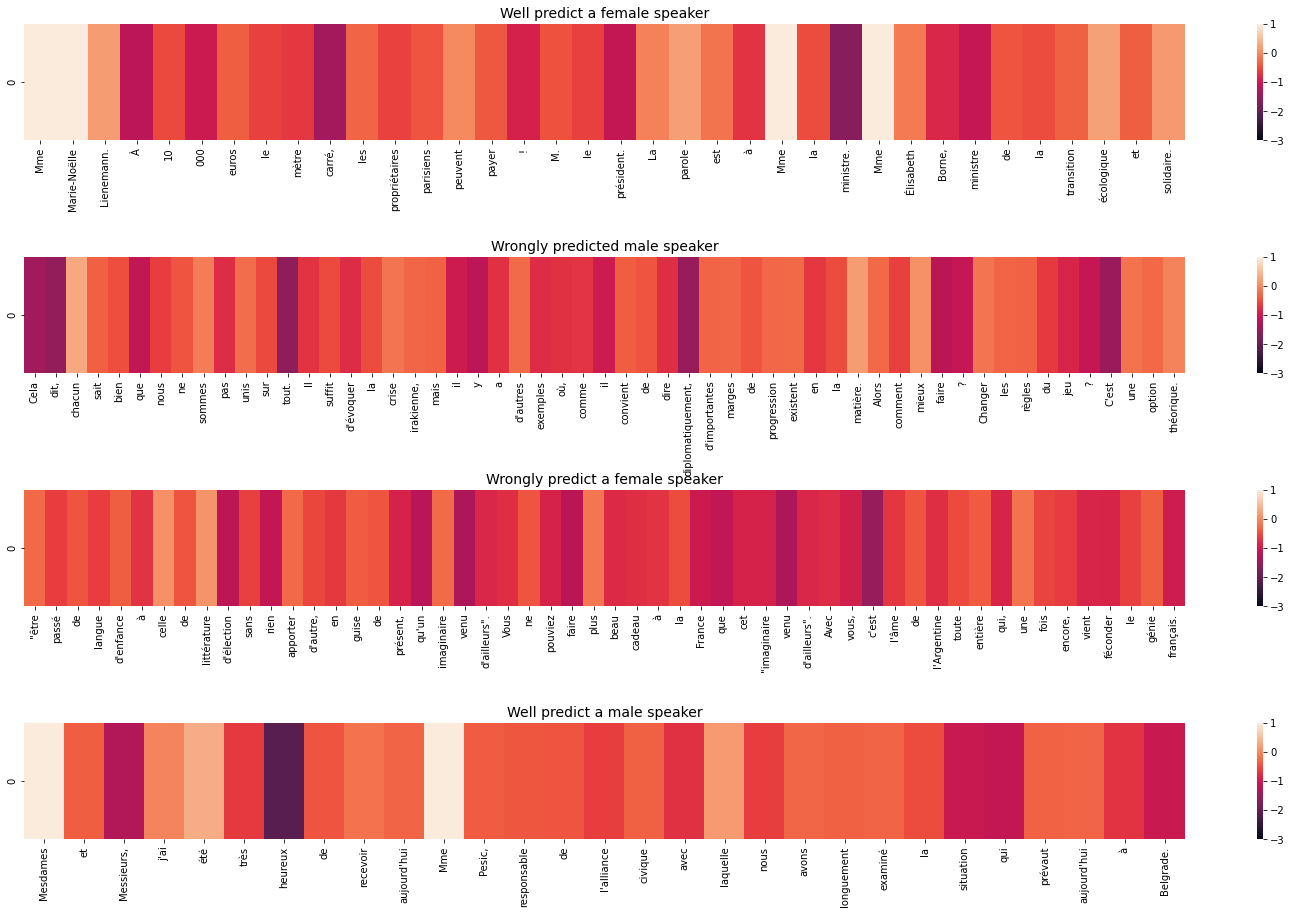

In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(26,15))

#  heatmap - female subplot
fig.add_subplot(411)
plt.title('Well predict a female speaker', fontsize=14)
sns.heatmap(df_plot_true_f, annot=False, fmt='.2f',vmin=-3,vmax=1)

#  heatmap - male subplot
fig.add_subplot(412)
plt.title('Wrongly predicted male speaker', fontsize=14)
sns.heatmap(df_plot_false_m, annot=False, fmt='.2f',vmin=-3,vmax=1 )

#  heatmap - male subplot
fig.add_subplot(413)
plt.title('Wrongly predict a female speaker', fontsize=14)
sns.heatmap(df_plot_false_f, annot=False, fmt='.2f',vmin=-3,vmax=1 )

#  heatmap - male subplot
fig.add_subplot(414)
plt.title('Well predict a male speaker', fontsize=14)
sns.heatmap(df_plot_true_m, annot=False, fmt='.2f',vmin=-3,vmax=1 )

plt.subplots_adjust(hspace=1)
#fig.tight_layout(pad=3.0)
plt.show()
